<a href="https://colab.research.google.com/github/arny617/MLNanodegree/blob/master/CryptoSentimentAnalysis_TransferLearningBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from scipy.spatial.distance import cosine as dist

In [4]:
torch.cuda.set_device(0)

In [6]:
import pandas as pd
import numpy as np
#import OpenBlender
import json

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Openblender

In [ ]:
!pip install OpenBlender

     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 245kB 20.5MB/s 
  Created wheel for OpenBlender: filename=OpenBlender-2.6-cp36-none-any.whl size=6607 sha256=426da6367f6629f0bf05b31689bc17a2aab82e7b5f6e327a6c4eebdc18add676
  Stored in directory: /root/.cache/pip/wheels/fd/29/7b/377afef16a792ed174a9ade5a6707ef87843e214476d0c8205
Successfully built OpenBlender


In [ ]:
api_token = '5fc5ad47951629617230bee5MDHzrVvlWhz1MZm92QeQqc5DrybPBT'

In [ ]:
action = 'API_getObservationsFromDataset'# ANCHOR: 'Bitcoin vs USD'
  
parameters = { 
    'token' : api_token,
    'id_dataset' : '5d4c3af79516290b01c83f51',
    'date_filter':{"start_date" : "2020-01-01",
                   "end_date" : "2020-08-29"} }
df = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
df.reset_index(drop=True, inplace=True)
df['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in df.timestamp]
df = df.drop('timestamp', axis = 1)

Task ID: '5fc8697c0895fafb4a9d8d4b'.
Total estimated consumption: 5832.61 processing units.
Task confirmed. Starting download..
100.0 % completed.


In [8]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
ROOT = "/content/gdrive/My Drive/Colab Notebooks/NLP/Fast.ai_IntroToNLP/"
os.chdir(ROOT)

Mounted at /content/gdrive


In [ ]:
df.to_excel("BitcoinData.xlsx")

In [ ]:
df.describe()

,price,high,low,open
count,236.000000,236.000000,236.000000,236.000000
mean,8924.639831,9102.731780,8713.850000,8915.802966
std,1527.913626,1487.242123,1533.155692,1495.375999
min,4927.000000,5381.900000,4468.000000,5339.000000
25%,7969.025000,8140.225000,7694.625000,7892.775000
50%,9184.150000,9299.500000,9056.100000,9176.900000
75%,9678.950000,9859.700000,9464.350000,9672.500000
max,12300.000000,12415.000000,11927.200000,12300.000000


In [ ]:
df['log_ret'] = np.log(df['price']) - np.log(df['open'])

In [ ]:
df.sort_index(inplace=True,ascending=False)

In [ ]:
df.tail()

,volume,price,high,low,open,change,date,log_ret
4,1.93K,11663.0,11692.6,11551.0,11685.0,-0.19%,23-08-2020 17:00:00,-0.001885
3,6.16K,11341.0,11768.0,11200.0,11768.0,-3.63%,25-08-2020 17:00:00,-0.036960
2,2.48K,11471.0,11482.0,11316.0,11341.0,1.15%,26-08-2020 17:00:00,0.011398
1,4.81K,11343.0,11471.1,11254.0,11471.1,-1.12%,27-08-2020 17:00:00,-0.011230
0,2.02K,11545.0,11545.0,11343.0,11343.0,1.78%,28-08-2020 17:00:00,0.017652


In [ ]:
df.tail()

,volume,price,high,low,open,change,date,log_ret
153,3.69K,9452.1,9707.2,9402.6,9706.4,-2.62%,31-05-2020 17:00:00,-0.026549
94,5.83K,11350.0,11378.0,11038.0,11123.0,2.04%,31-07-2020 17:00:00,0.020203
67,2.24K,11671.0,11734.0,11639.1,11729.9,-0.50%,31-08-2020 17:00:00,-0.005034
22,8.95K,13788.0,13958.0,13499.0,13568.0,1.62%,31-10-2020 17:00:00,0.016085
306,2.99K,7208.3,7333.0,7161.3,7261.0,-0.72%,31-12-2019 17:00:00,-0.007284


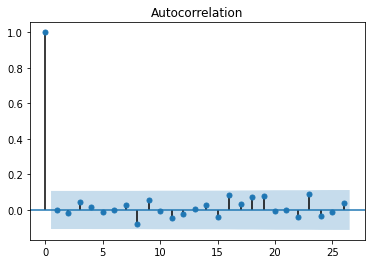

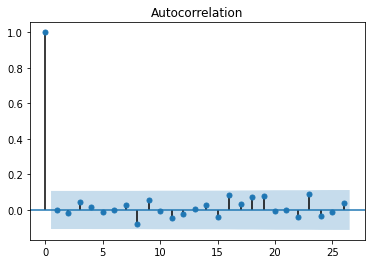

In [ ]:
plot_acf(df['log_ret'])

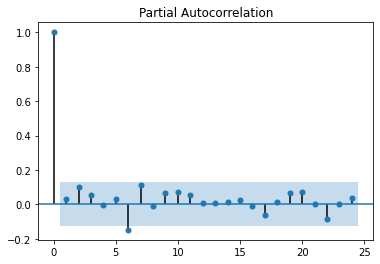

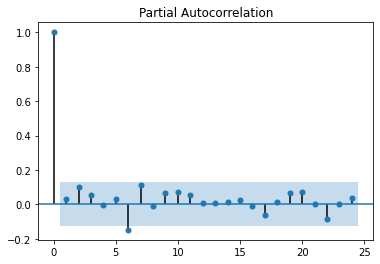

In [ ]:
plot_pacf(df['log_ret'])

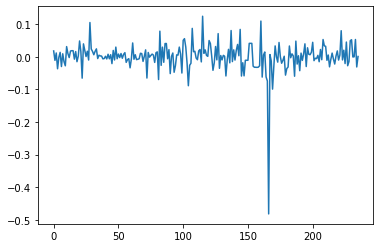

In [ ]:
plt.plot(df['log_ret'])

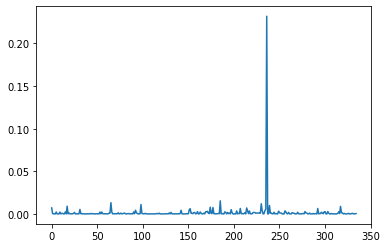

In [ ]:
plt.plot(df['log_ret']**2)

In [ ]:
df['price']

334     7450.1
333     7350.3
332     7336.0
331     7238.2
330     7440.0
        ...   
172     8811.4
141     9468.3
112     9315.8
84     11591.0
40     11560.0
Name: price, Length: 335, dtype: float64

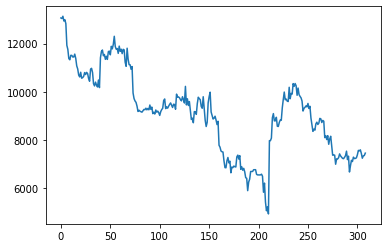

In [ ]:
plt.plot(df['price'])

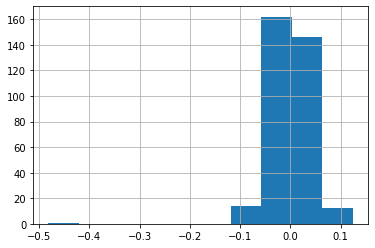

In [ ]:
df['log_ret'].hist()

In [ ]:
df['target'] = [1 if log_diff > 0 else 0 for log_diff in df['log_ret']]

In [ ]:
df.reset_index(inplace=True)
df.head()

,index,volume,price,high,low,open,change,date,log_ret,target
0,235,2.07K,7212.7,7268.8,7185.4,7208.2,0.06%,01-01-2020 17:00:00,0.000624,1
1,234,4.85K,6989.4,7225.2,6963.0,7212.7,-3.10%,02-01-2020 17:00:00,-0.031449,0
2,233,6.68K,7367.5,7437.6,6909.3,6989.4,5.41%,03-01-2020 17:00:00,0.052684,1
3,232,4.27K,7369.8,7422.0,7297.7,7371.8,0.03%,04-01-2020 17:00:00,-0.000271,0
4,231,4.45K,7364.6,7509.9,7315.8,7370.3,-0.07%,05-01-2020 17:00:00,-0.000774,0


In [ ]:
format = '%d-%m-%Y %H:%M:%S'
timezone = 'GMT'
df['u_timestamp'] = OpenBlender.dateToUnix(df['date'], 
                                           date_format = format, 
                                           timezone = timezone)
df = df[['date', 'u_timestamp', 'price', 'target']]
df.head()

,date,u_timestamp,price,target
0,28-08-2020 17:00:00,1.598634e+09,11545.0,1
1,27-08-2020 17:00:00,1.598548e+09,11343.0,0
2,26-08-2020 17:00:00,1.598461e+09,11471.0,1
3,25-08-2020 17:00:00,1.598375e+09,11341.0,0
4,23-08-2020 17:00:00,1.598202e+09,11663.0,0


In [ ]:
search_keyword = 'bitcoin'
df = df.sort_values('u_timestamp').reset_index(drop = True)
print('From : ' + OpenBlender.unixToDate(min(df.u_timestamp)))
print('Until: ' + OpenBlender.unixToDate(max(df.u_timestamp)))
OpenBlender.searchTimeBlends(api_token,df.u_timestamp,search_keyword)

From : 01-01-2020 17:00:00
Until: 28-08-2020 17:00:00


[{'description': 'Daily prices and volumes for the digital currency BitcoinsCash.',
  'features': ['close',
   'high',
   'low',
   'market_cap',
   'open',
   'timestamp',
   'volume'],
  'id_dataset': '5d9f899b951629329a748593',
  'intersection': '100%',
  'name': 'Bitcoins Cash Historical data',
  'num_observations': 1183,
  'url': 'https://www.openblender.io/#/dataset/explore/5d9f899b951629329a748593'},
 {'description': 'Daily Price of Bitcoin SV',
  'features': ['change',
   'high',
   'low',
   'open',
   'price',
   'timestamp',
   'volume'],
  'id_dataset': '5db7a7c99516294f3f6c2faf',
  'intersection': '100%',
  'name': 'Bitcoin SV Price',
  'num_observations': 318,
  'url': 'https://www.openblender.io/#/dataset/explore/5db7a7c99516294f3f6c2faf'},
 {'description': 'Daily Price of Bitcoin Gold',
  'features': ['change',
   'high',
   'low',
   'open',
   'price',
   'timestamp',
   'volume'],
  'id_dataset': '5db7aa0b9516294f3f6c30ca',
  'intersection': '100%',
  'name': 'Bitcoi

In [ ]:
!pip install fsspec

     |████████████████████████████████| 92kB 5.0MB/s 


In [ ]:
alt_source = {
                'id_dataset':'5ea20ec595162936337159b4',
                'feature' : 'text'
            }
# Now, let's 'timeBlend' it to our dataset
df_blend_alt = OpenBlender.timeBlend( token = api_token,
                                  anchor_ts = df.u_timestamp,
                                  blend_source = alt_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list',
                                  missing_values = 'raw')

Task ID: '5fc869d80895fafb4a9d8d4c'.
Total estimated consumption: 9440.0 processing units.
Task confirmed. Starting download..
100%


In [ ]:
df_blend_alt.head()

,timestamp,COINNOUNCE.text_COUNT_last1days,COINNOUNCE.text_last1days
0,1577898000,0,[]
1,1577984400,0,[]
2,1578070800,0,[]
3,1578157200,0,[]
4,1578243600,0,[]


In [ ]:
# We need to add the 'id_dataset' and the 'feature' name we want.

blend_source = {
                'id_dataset':'5ea2039095162936337156c9',
                'feature' : 'text'
            }
# Now, let's 'timeBlend' it to our dataset
df_blend = OpenBlender.timeBlend( token = api_token,
                                  anchor_ts = df.u_timestamp,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list',
                                  missing_values = 'raw')
df = pd.concat([df, df_blend.loc[:, df_blend.columns != 'u_timestamp']], axis = 1)
df.head()

Task ID: '5fc869e60895fafb4a9d8d4c'.
Total estimated consumption: 9440.0 processing units.
Task confirmed. Starting download..
100%


,date,u_timestamp,price,target,timestamp,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days
0,28-08-2020 17:00:00,1.598634e+09,11545.0,1,1577898000,3,[etoro ceo yoni assia on reaching 12 million u...
1,27-08-2020 17:00:00,1.598548e+09,11343.0,0,1577984400,7,[government confirms crypto profits not taxabl...
2,26-08-2020 17:00:00,1.598461e+09,11471.0,1,1578070800,8,[ticker tool uses the bch blockchain to provid...
3,25-08-2020 17:00:00,1.598375e+09,11341.0,0,1578157200,6,[crypto fundraising is changing again in 2020 ...
4,23-08-2020 17:00:00,1.598202e+09,11663.0,0,1578243600,5,[subhash chandra garg on the future of crypto ...


In [ ]:
df = pd.concat([df, df_blend_alt.loc[:, df_blend_alt.columns != 'u_timestamp']], axis = 1)

In [ ]:
df.head()

,date,u_timestamp,price,target,timestamp,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days,timestamp,COINNOUNCE.text_COUNT_last1days,COINNOUNCE.text_last1days
0,28-08-2020 17:00:00,1.598634e+09,11545.0,1,1577898000,3,[etoro ceo yoni assia on reaching 12 million u...,1577898000,0,[]
1,27-08-2020 17:00:00,1.598548e+09,11343.0,0,1577984400,7,[government confirms crypto profits not taxabl...,1577984400,0,[]
2,26-08-2020 17:00:00,1.598461e+09,11471.0,1,1578070800,8,[ticker tool uses the bch blockchain to provid...,1578070800,0,[]
3,25-08-2020 17:00:00,1.598375e+09,11341.0,0,1578157200,6,[crypto fundraising is changing again in 2020 ...,1578157200,0,[]
4,23-08-2020 17:00:00,1.598202e+09,11663.0,0,1578243600,5,[subhash chandra garg on the future of crypto ...,1578243600,0,[]


In [ ]:
df.head()

,date,u_timestamp,price,target,timestamp,BITCOIN_NE.text_COUNT_last1days,text,timestamp,COINNOUNCE.text_COUNT_last1days,text_alt
0,28-08-2020 17:00:00,1.598634e+09,11545.0,1,1577898000,3,[etoro ceo yoni assia on reaching 12 million u...,1577898000,0,[]
1,27-08-2020 17:00:00,1.598548e+09,11343.0,0,1577984400,7,[government confirms crypto profits not taxabl...,1577984400,0,[]
2,26-08-2020 17:00:00,1.598461e+09,11471.0,1,1578070800,8,[ticker tool uses the bch blockchain to provid...,1578070800,0,[]
3,25-08-2020 17:00:00,1.598375e+09,11341.0,0,1578157200,6,[crypto fundraising is changing again in 2020 ...,1578157200,0,[]
4,23-08-2020 17:00:00,1.598202e+09,11663.0,0,1578243600,5,[subhash chandra garg on the future of crypto ...,1578243600,0,[]


In [ ]:
df.rename(columns={'BITCOIN_NE.text_last1days':'text','COINNOUNCE.text_last1days':'text_alt'},inplace=True)

In [ ]:

df['text'] = df['text'].apply(lambda x:"xxeos ".join(x))
df['text_alt'] = df['text_alt'].apply(lambda x:"xxeos ".join(x))

In [ ]:
df.head()

,date,u_timestamp,price,target,timestamp,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days,text
0,01-01-2020 17:00:00,1.577898e+09,7212.7,1,1577898000,3,[etoro ceo yoni assia on reaching 12 million u...,etoro ceo yoni assia on reaching 12 million us...
1,02-01-2020 17:00:00,1.577984e+09,6989.4,0,1577984400,7,[government confirms crypto profits not taxabl...,government confirms crypto profits not taxable...
2,03-01-2020 17:00:00,1.578071e+09,7367.5,1,1578070800,8,[ticker tool uses the bch blockchain to provid...,ticker tool uses the bch blockchain to provide...
3,04-01-2020 17:00:00,1.578157e+09,7369.8,0,1578157200,6,[crypto fundraising is changing again in 2020 ...,crypto fundraising is changing again in 2020 x...
4,05-01-2020 17:00:00,1.578244e+09,7364.6,0,1578243600,5,[subhash chandra garg on the future of crypto ...,subhash chandra garg on the future of crypto x...


In [ ]:
df['text'].values

array(['etoro ceo yoni assia on reaching 12 million users and why cryptos are a gateway to stocks xxeos china takes another step away from usd hegemony xxeos veriblock captured close to 60 of btcs op return transactions in 2019 ',
       'government confirms crypto profits not taxable in south korea xxeos wifi sharing platform wicrypt gets government grant in nigeria xxeos tronbased tether has ballooned to over 900 million tokens almost 22 of total supply xxeos these are the bitcoin stories you loved in 2019 xxeos alleged 8b btc tulip trust expires with tales of bonded couriers xxeos using a vpn may get israeli crypto traders in trouble xxeos why nick szabo probably isnt satoshi ',
       'ticker tool uses the bch blockchain to provide reliable rate data xxeos was youtubes christmas crypto purge illegal xxeos early cypherpunk emails reveal a blueprint for bitcoin xxeos google restores metamask app after community uproar xxeos btcs hashrate touches 120 exahash but the price has not foll

In [ ]:
df['BITCOIN_NE.text_last1days'].apply(lambda x:["".join(k) for k in x])

0      [etoro ceo yoni assia on reaching 12 million u...
1      [government confirms crypto profits not taxabl...
2      [ticker tool uses the bch blockchain to provid...
3      [crypto fundraising is changing again in 2020 ...
4      [subhash chandra garg on the future of crypto ...
                             ...                        
231                                                   []
232                                                   []
233                                                   []
234                                                   []
235                                                   []
Name: BITCOIN_NE.text_last1days, Length: 236, dtype: object

### Load Pre Saved Data

In [9]:
df_anchor = pd.read_csv("BTC_Final.csv",usecols=[1,2,3,4,5,6,7,8,9,10])

In [10]:
df_anchor.head()

,date,u_timestamp,price,target,timestamp,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days,text,text_polarity,text_subjectivity
0,28-08-2020 17:00:00,1.598634e+09,11545.0,1,1577898000,3,['etoro ceo yoni assia on reaching 12 million ...,etoro ceo yoni assia on reaching 12 million us...,"{'neg': 0.0, 'neu': 0.954, 'pos': 0.046, 'comp...",0.000000
1,27-08-2020 17:00:00,1.598548e+09,11343.0,0,1577984400,7,['government confirms crypto profits not taxab...,government confirms crypto profits not taxable...,"{'neg': 0.032, 'neu': 0.787, 'pos': 0.181, 'co...",0.462500
2,26-08-2020 17:00:00,1.598461e+09,11471.0,1,1578070800,8,['ticker tool uses the bch blockchain to provi...,ticker tool uses the bch blockchain to provide...,"{'neg': 0.122, 'neu': 0.785, 'pos': 0.093, 'co...",0.254167
3,25-08-2020 17:00:00,1.598375e+09,11341.0,0,1578157200,6,['crypto fundraising is changing again in 2020...,crypto fundraising is changing again in 2020 x...,"{'neg': 0.063, 'neu': 0.847, 'pos': 0.09, 'com...",0.518182
4,23-08-2020 17:00:00,1.598202e+09,11663.0,0,1578243600,5,['subhash chandra garg on the future of crypto...,subhash chandra garg on the future of crypto x...,"{'neg': 0.049, 'neu': 0.772, 'pos': 0.179, 'co...",0.319886


In [41]:
df_anchor.dropna(inplace=True)

In [11]:
from ast import literal_eval

In [12]:
def try_literal_eval(s):
    try:
        return literal_eval(s)
    except ValueError:
        return s

In [13]:
df_anchor["text_polarity"] = df_anchor["text_polarity"].apply(lambda x:try_literal_eval(x))

In [14]:
df_anchor["text_posneg"] = df_anchor["text_polarity"].apply(lambda x : 0 if x["neg"]==0.0 else x["pos"]/x["neg"]) 

In [15]:
df_anchor["text_polarity"] = df_anchor["text_polarity"].apply(lambda x : x["compound"]) 

In [ ]:
from fastai.text import *

In [17]:
!pip install transformers

     |████████████████████████████████| 1.4MB 11.4MB/s 
     |████████████████████████████████| 2.9MB 42.5MB/s 
     |████████████████████████████████| 890kB 39.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4df40d2d2e1e60da6811a13b0e31449592f66ba0ca9bf86ffbb89a6cea69d6ca
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [87]:
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}
    
#model_type = 'roberta'
model_type = 'bert'

model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]
#pretrained_model_name = 'roberta-base'
pretrained_model_name = 'bert-base-uncased'
model_name = pretrained_model_name

In [88]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = 20
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens
        
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [89]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [90]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [91]:
bs = 48

In [92]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

databunch = (TextList.from_df(df_anchor, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.2,seed=42)
             .label_from_df(cols= 'target')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [93]:
class CustomTransformerModel(nn.Module):
  
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits

In [94]:
config = config_class.from_pretrained(model_name)
config.num_labels = 2

transformer_model = model_class.from_pretrained(model_name, config = config)
# transformer_model = model_class.from_pretrained(model_name, num_labels = 5)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [98]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy])

In [ ]:
list_layers = [learner.model.transformer.distilbert.embeddings,
               learner.model.transformer.distilbert.transformer.layer[0] ,
               learner.model.transformer.distilbert.transformer.layer[1],
               learner.model.transformer.distilbert.transformer.layer[2],
               learner.model.transformer.distilbert.transformer.layer[3],
               learner.model.transformer.distilbert.transformer.layer[4],
               learner.model.transformer.distilbert.transformer.layer[5],
               learner.model.transformer.pre_classifier]
               
learner.split(list_layers)

In [100]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


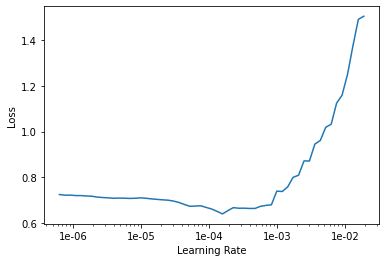

In [101]:
learner.recorder.plot()

In [102]:
# Tune a little more
learner.freeze_to(-1)

In [103]:
# Fit the model based on selected learning rate
learner.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.770580,67.428253,0.600000,00:01


In [109]:
learner.freeze_to(-2)
learner.fit_one_cycle(5, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.900092,0.717055,0.600000,00:01
1,2.747047,0.694976,0.400000,00:01
2,2.452689,3.802555,0.400000,00:01
3,2.533840,1.583624,0.600000,00:01
4,2.400381,1.344234,0.600000,00:01


In [110]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, 2e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.903157,0.854397,0.400000,00:01


In [111]:
learner.fit_one_cycle(1, 2e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.799990,0.680405,0.600000,00:01


In [113]:
learner.fit_one_cycle(1, 2e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.600638,0.685512,0.600000,00:01


In [114]:
learner.show_results()

text,target,prediction
[CLS] ether ##eum tr ##on and e ##os control 98 of all da ##pp volume xx ##eo ##s 6 [SEP],0,1
[CLS] demand for bit ##co ##in will see a dramatic shift in 8 years retail addresses to eat up [SEP],1,1
[CLS] chinese ken ##nel owner caught stealing electricity to power underground bit ##co ##in mining farm xx ##eo ##s [SEP],1,1
[CLS] market update crypt ##o cap near ##s 300 billion bt ##c hits 10 ##k et ##h rallies hard [SEP],0,1
[CLS] swiss government rejects 103 million bail ##out for crypt ##o companies battered by corona ##virus xx ##eo ##s [SEP],0,1


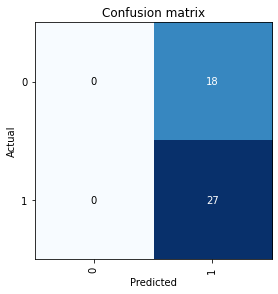

In [115]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [116]:
y_valid = interp.data.valid_ds.y.items

In [117]:
y_pred = interp.pred_class.numpy()

In [118]:
from sklearn.metrics import classification_report
print(classification_report(y_valid,
                            y_pred,
                            target_names= ['0', '1']))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.60      1.00      0.75        27

    accuracy                           0.60        45
   macro avg       0.30      0.50      0.37        45
weighted avg       0.36      0.60      0.45        45



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
